# Univariat tidsserieanalyse og prognostisering

In [ ]:
# importing libraries 

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib

plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
print('setup completed')

setup completed


## Data
Bruker dataen 'Sample - Superstore' som ble brrukt under Tableau-opplæring

In [ ]:
# lese excel-filen
varer = pd.read_excel('Downloads/Superstore.xls')
varer.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [ ]:
varer.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


## Databehandling

In [ ]:
varer.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [ ]:
# Ta bort kolonner som ikke kreves i prediksjonene

cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
varer.drop(cols, axis = 1, inplace = True)
varer.head()

,Order Date,Sales
0,2016-11-08,261.9600
1,2016-11-08,731.9400
2,2016-06-12,14.6200
3,2015-10-11,957.5775
4,2015-10-11,22.3680


In [ ]:
# Sortere ordredato (Order Date) 
varer = varer.sort_values('Order Date')

# Printe de sorterte verdiene
print(varer.head(1))

# Sjekke eventuelle manglende verdier
varer.isnull().sum()

     Order Date   Sales
7980 2014-01-03  16.448


Order Date    0
Sales         0
dtype: int64

In [ ]:
# Gruppere salg etter ordredat (Order Date)
varer.groupby('Order Date')['Sales'].sum().reset_index()

# min og max verdier av ordredato (Order Date)
print(varer['Order Date'].min())
print(varer['Order Date'].max())

2014-01-03 00:00:00
2017-12-30 00:00:00


In [ ]:
# Sette 'Order Date' som indeks
varer = varer.set_index('Order Date')
varer.index

DatetimeIndex(['2014-01-03', '2014-01-04', '2014-01-04', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-06', '2014-01-06',
               '2014-01-06', '2014-01-06',
               ...
               '2017-12-29', '2017-12-29', '2017-12-29', '2017-12-30',
               '2017-12-30', '2017-12-30', '2017-12-30', '2017-12-30',
               '2017-12-30', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=9994, freq=None)

In [ ]:
# Til gjennomsnittet av den daglige salgsverdien for hver måned
# Bruke starten av hver måned som tidsstempel
y = varer['Sales'].resample('MS').mean()
y['2017':]

Order Date
2017-01-01    283.686284
2017-02-01    189.730219
2017-03-01    247.362827
2017-04-01    179.909045
2017-05-01    182.897150
2017-06-01    216.251942
2017-07-01    200.285027
2017-08-01    289.545358
2017-09-01    191.430614
2017-10-01    260.996387
2017-11-01    258.056264
2017-12-01    181.448742
Freq: MS, Name: Sales, dtype: float64

### Datavisualisering

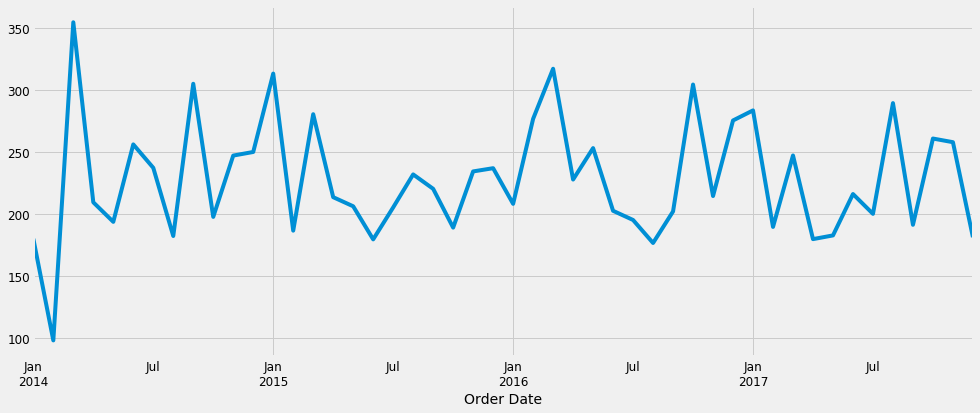

In [ ]:
y.plot(figsize = (15, 6))
plt.show()

## Tidsserie nedbryting 
Bryte ned tidsseriene i tre forskjellige komponenter
- Trend
- Sesong
- Støy

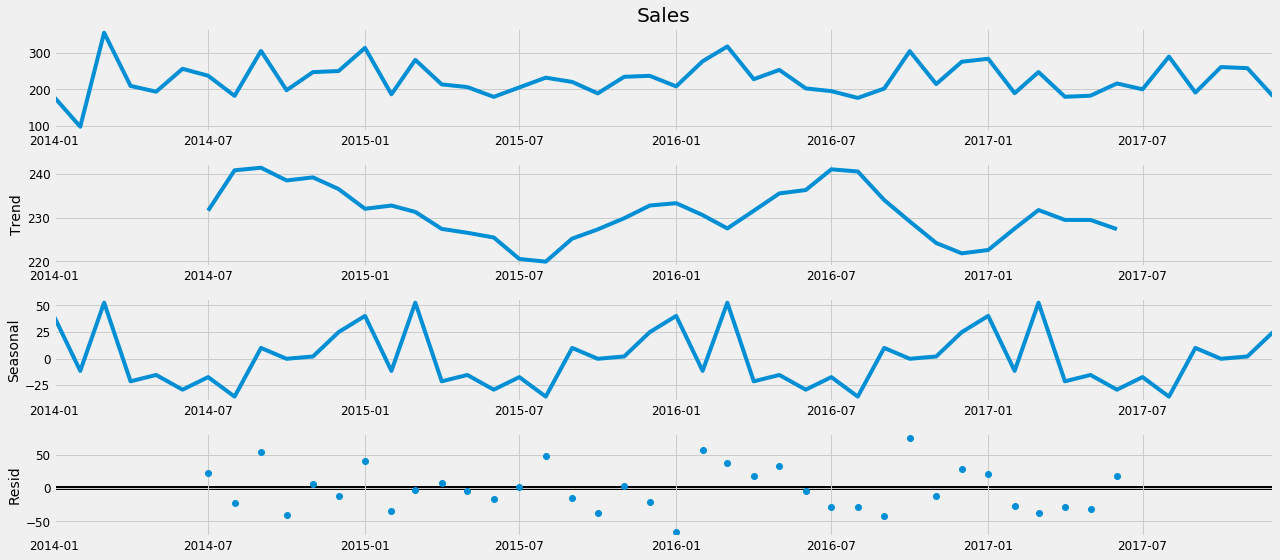

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

nedbryting = sm.tsa.seasonal_decompose(y, model = 'additive')
fig = nedbryting.plot()
plt.show()

### Tidsserievarsling med ARIMA-modell - Autoregressive Integrated Moving Average

ARIMA-modeller er betegnet med notasjonen AR(p), I(d), and MA(q)
Disse tre parameterne står for data om sesong, trend og støy

In [ ]:
# Angi de typiske områdene for p, d, q
p = d = q = range(0, 2)

# Ta alle mulige kombinasjoner for p, d og q
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Eksempler på parameterkombinasjoner for sesongbaserte Arima...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Eksempler på parameterkombinasjoner for sesongbaserte Arima...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
# Bruke Grid Search for å finne det optimale settet med parametere som gir den beste ytelsen 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order = param, seasonal_order = param_seasonal, enforce_stationary = False,enforce_invertibility=False) 
            result = mod.fit()   
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, result.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:661.5238453481245


/Users/rogerk.barclet/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rogerk.barclet/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1530.1188634886466
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:402.0746678479151
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:396.8202649808119
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:568.0812131278186
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:563.3702893253451
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:395.73870136528853
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:397.71036079875597
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:624.7073376670585


/Users/rogerk.barclet/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1810.2304380200924
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:404.05723836320936
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:398.30739030836577
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:565.8511871084463
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:563.4641113510612
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:397.26524843861034
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:399.1166245099266
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:539.8605974537222


/Users/rogerk.barclet/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1514.0760487595367
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:413.4421987150406
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:411.77118682004146
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:540.1473655055304


/Users/rogerk.barclet/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1794.9501198623366
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:411.1502241605039
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:413.0349618315353
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:505.2494190718203


/Users/rogerk.barclet/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1816.448323360188
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:397.5664610839762
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:393.23114179460725
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:507.0099455851324


/Users/rogerk.barclet/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1973.447782029938
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:392.0933287553441
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:394.0906684872561
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:553.994504891966
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:2197.9187766509745


/Users/rogerk.barclet/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:404.06203007562067
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:398.38088151786945
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:552.9272857949779
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:553.5803860727674
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:397.27571034278105
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:399.14714147391214


/Users/rogerk.barclet/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:520.9333638479932
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1870.601615341067
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:405.50341283577484
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:397.0752637439929


/Users/rogerk.barclet/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:522.7669073462336
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:524.7166919197903
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:396.0818242406228
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:397.9267379151583
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:519.8818905467281


/Users/rogerk.barclet/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:2024.2579186466521
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:408.0593708055174
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:402.67176668680275
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:521.8609414870466


/Users/rogerk.barclet/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:2409.3859447341206
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:399.8530806573022
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:401.49865809140636
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:505.56288669332525


/Users/rogerk.barclet/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1924.3327282280227
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:399.56190080713714
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:395.0251886261328
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:507.5224773702355


/Users/rogerk.barclet/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1911.6956656586049
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:393.8481987643711
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:395.8117139867413


### Modell Fitting

In [ ]:
# Fitting av ARIMA-modellen ved bruk av optimal kombinasjon av p, d, q (optimal kombinasjon der vi fikk laveste AIC-poengsum)

model = sm.tsa.statespace.SARIMAX(y, order = (1, 1, 1),
                                  seasonal_order = (1, 1, 0, 12)
                                 )
result = model.fit()
print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0913      0.286     -0.319      0.750      -0.651       0.469
ma.L1         -0.9982      9.598     -0.104      0.917     -19.810      17.813
ar.S.L12      -0.5598      0.156     -3.594      0.000      -0.865      -0.254
sigma2      2799.1392   2.67e+04      0.105      0.917   -4.95e+04    5.51e+04


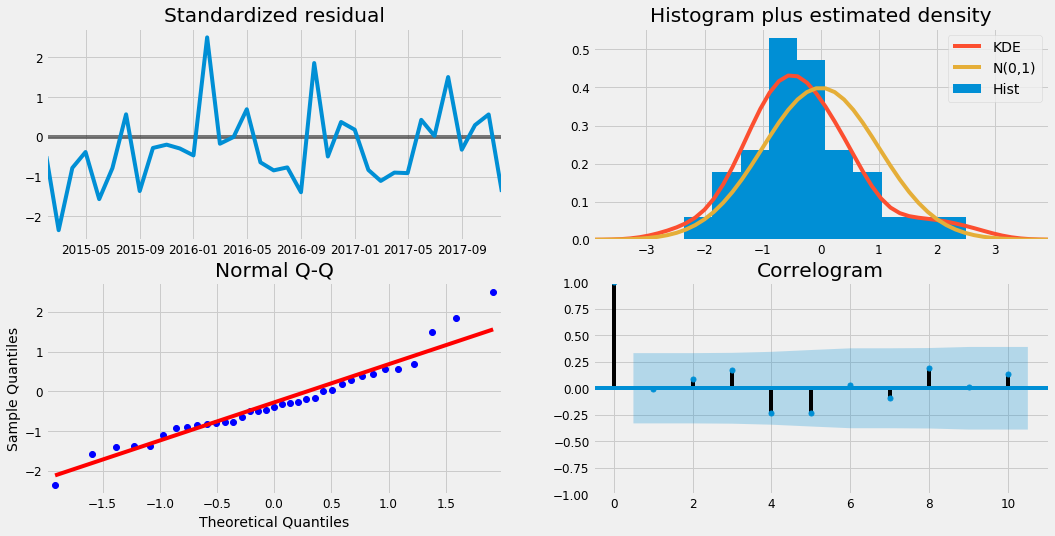

In [ ]:
# Kjøre diagnostikkmodell for å undersøke evt. uvanlig atferd
result.plot_diagnostics(figsize = (16, 8))
plt.show()

Langt fra perfekt men modelldiagnostikken antyder at modellresidualene er nær normalt distribuert

### Validering av prognoser 
For å hjelpe oss med å forstå nøyaktigheten med våre prognoser vil vi nå sammenligne vi prognotiserte salg med reelle salg fra tidsserien: Vi setter prognoserene til å starte 01.01.2017 til slutten av dataene.

In [ ]:
prediction = result.get_prediction(start = pd.to_datetime('2017-01-01'), dynamic = False)
prediction_ci = prediction.conf_int()
prediction_ci

,lower Sales,upper Sales
Order Date,,
2017-01-01,166.949832,380.855434
2017-02-01,128.374778,341.873712
2017-03-01,201.126555,414.265413
2017-04-01,122.357192,335.174992
2017-05-01,126.153432,338.683177
2017-06-01,87.013283,299.283138
2017-07-01,92.953018,304.987209
2017-08-01,102.323361,314.142880
2017-09-01,103.098062,314.721215


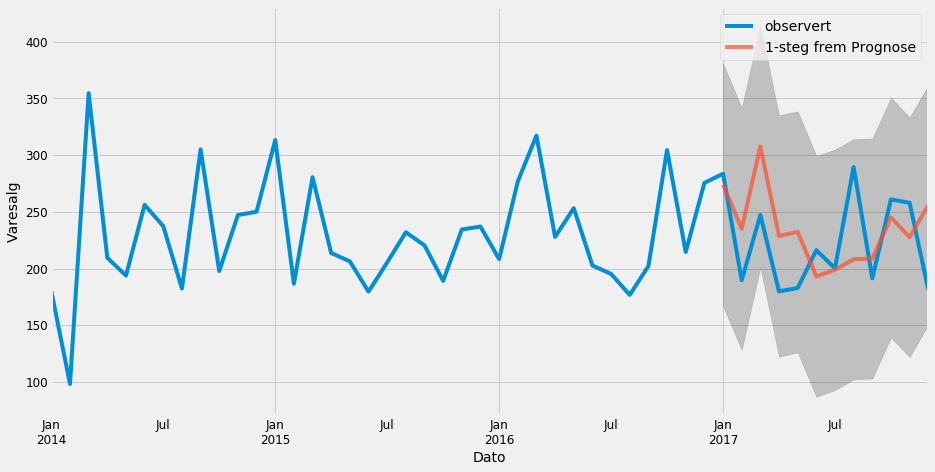

In [ ]:
#Visualisere prognosen
ax = y['2014':].plot(label = 'observert')
prediction.predicted_mean.plot(ax = ax, label = '1-steg frem Prognose', alpha = 0.7, figsize = (14, 7))
ax.fill_between(prediction_ci.index, prediction_ci.iloc[:, 0], prediction_ci.iloc[:, 1], color = 'k', alpha = 0.2)
ax.set_xlabel("Dato")
ax.set_ylabel('Varesalg')
plt.legend()
plt.show()

Linjeplottet viser de observerte verdiene sammenlignet med de rullende prognosene. Samlet sett stemmer våre prognoser veldig godt overens med de sanne verdiene, og viser en oppadgående trend fra begynnelsen av året og fanget sesongmessigheten mot slutten av året.

### Feilanalyse

In [ ]:
# Evalueringsmålinger er Squared Mean Error (SME) og Root Mean Squared Error (RMSE)
y_hat = prediction.predicted_mean
y_truth = y['2017-01-01':]

mse = ((y_hat - y_truth) ** 2).mean()
rmse = np.sqrt(mse)
print('MSE (Mean Squared Error) til prognosen er: {}'.format(round(mse, 2)))
print('Kvadrat MSE (Root Mean Squared Error) til prognosen er {}'.format(round(rmse, 2)))

MSE (Mean Squared Error) til prognosen er: 2069.58
Kvadrat MSE (Root Mean Squared Error) til prognosen er 45.49


### Produsere og visualisere prognoser

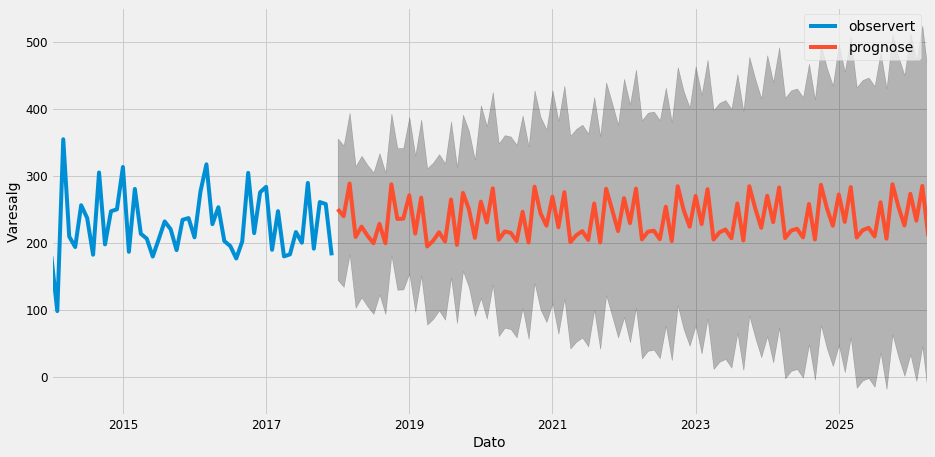

In [ ]:
# Prognotisering 
pred_uc = result.get_forecast(steps = 100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label = 'observert', figsize = (14, 7))
pred_uc.predicted_mean.plot(ax = ax, label = 'prognose')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color = 'k', alpha = 0.25)
ax.set_xlabel('Dato')
ax.set_ylabel('Varesalg')

plt.legend()
plt.show()

### Oppsummering
Modellen fanget på en tydelig måte møbelsalgssesongaliteten. Når vi lager prognoser lenger frem i fremtiden, er det naturlig å bli mindre trygge på tallene som dukker opp. Dette gjenspeiles av konfidens intervallene som genereres av modellen vår. De blir større når vi beveger oss lenger frem i tiden.